In [75]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.patches as patches
import matplotlib.colors as colors
from scipy.spatial.distance import cdist
import matplotlib.path as pth

In [177]:
class StackGeometry:
    def __init__(self, number_of_rings, pitch):
        self.nRings = number_of_rings
        self.corePitch = pitch
        self.latticePoints = []
        self.coreLocations = []

    def build_triangular_lattice(self):
        # Loop through all lattice points in a triangular pattern
        for i in range(2*self.nRings +1):
            for j in range(2*self.nRings +1):
                x = j * self.corePitch
                y = i * self.corePitch * 0.8660254  # 0.8660254 is the sine of 60 degrees
                
                # Shift every other row of lattice points
                if i % 2 == 1:
                    x += self.corePitch / 2
                    
                # Append the lattice point to the list of points
                self.latticePoints.append((x, y))
        
        # Shift the lattice points so that the center is at the origin
        if self.nRings % 2 == 1:
            self.latticePoints = np.array(self.latticePoints) - np.array([self.nRings*self.corePitch +  self.corePitch / 2, self.nRings* self.corePitch * 0.8660254 ])
        else:
            self.latticePoints = np.array(self.latticePoints) - np.array([self.nRings*self.corePitch, self.nRings* self.corePitch * 0.8660254 ])

    def trim_lattice_to_fibre(self):
        # Calculate maximum x and y coordinates for the hexagon bounding the lattice points
        max_xr = (self.nRings)*self.corePitch 
        max_yr = (self.nRings+1)*self.corePitch * 0.8660254 - 0.001
        
        # Define the vertices of the hexagon
        hexagon_coord_x = np.array([max_xr, max_xr/2 , -max_xr/2, -max_xr, -max_xr/2, max_xr/2, max_xr])
        hexagon_coord_y = np.array([0, max_yr, max_yr, 0, -max_yr, -max_yr, 0])
        
        # Create a path object that represents the hexagon
        hexagon_poly_points = list(zip(hexagon_coord_x, hexagon_coord_y))
        hexagon_path = pth.Path(hexagon_poly_points)
        
        # Remove lattice points outside the hexagon
        self.latticePoints = self.latticePoints[hexagon_path.contains_points(self.latticePoints)]
        
        # Find the lattice points that are too far from the center of the hexagon
        points_to_keep = np.where(cdist(self.latticePoints, np.array([[0,0]]), 'euclidean')<self.nRings*self.corePitch-0.00001 , False, True)
        
        # Remove the lattice points that are too far from the center of the hexagon
        index_to_keep = np.invert(np.any(points_to_keep, axis=1))
        self.latticePoints = self.latticePoints[index_to_keep]


    def add_cores_from_file(self, filepath):
        # Read in *.csv file with coords in the following form:
        #% Model	|honeycomb finite realistic design.mph   |
        #% Version	|COMSOL 6.0.0.405                        |    
        #% Date	    |Apr 3 2023, 15:29                       |
        #% Table	|Table 10 - Point Evaluation 3           |    
        #    x	    |     y                                  |   
        #  -25.143	|  -2.561703144                          |
        #   ...     |    ...                                 |   

        coord_data = pd.read_csv(filepath, skiprows=4) # skip 4 lines of COMSOL preamble
        self.coreLocations = np.stack([coord_data['x'].to_numpy(),coord_data['y'].to_numpy()], axis=1)

    def show_fibre_design(self):
        fig_circ = plt.figure(figsize=(9,5))
        axcirc = fig_circ.add_subplot(111)
        # draw appropriate v&w distances 
        outer_circ = self.corePitch
        # inner_circ = capillary_diameter*0.5#d_over_lambda
        core_circ_list = []
        inner_circ_list = []
        outer_circ_list = []

        for _point in self.latticePoints:
            outer_circ_list.append(patches.Circle(_point, radius=outer_circ/2, ec='black'))

        for _point in self.coreLocations:
            core_circ_list.append(patches.Circle(_point, radius=outer_circ/2, ec='black', fc='red'))
            

        for _circ in outer_circ_list:
            axcirc.add_patch(_circ)
        for _circ in core_circ_list:
            axcirc.add_patch(_circ)

        plt.axis('scaled')
        plt.show()

    def choose_jacket_tube(self, jacket_od, jacket_id):
        # use microns for all sizes
        self.jacketId = jacket_id
        self.jacketOd = jacket_od
    
    def choose_stack_tube(self, stack_od, stack_id):
        # use microns for all sizes
        self.stackId = stack_id
        self.stackOd = stack_od 
        self.capillaryDiameter = self.stackId/(2*self.nRings)
        print('Capillary Diameter Required: {}'.format(self.capillaryDiameter))

    def scale_lattice_to_stack_size(self):
        scale_factor_stack_to_cane = self.jacketId/self.stackOd
        scale_factor_cap_to_pitch = self.corePitch/self.capillaryDiameter
        scale_factor_cane_to_fib = scale_factor_cap_to_pitch/scale_factor_stack_to_cane
        print('Required Fibre Diamter: {}'.format(self.jacketOd*scale_factor_cane_to_fib))
        self.stackCoreLocations = self.coreLocations/scale_factor_cap_to_pitch
        self.stackLatticePoints = self.latticePoints/scale_factor_cap_to_pitch

    def show_stack_design(self):
        fig_circ = plt.figure(figsize=(9,5))
        axcirc = fig_circ.add_subplot(111)
        # inner_circ = capillary_diameter*0.5#d_over_lambda
        stack_core_circ_list = []
        # inner_circ_list = []
        stack_outer_circ_list = []
        
        axcirc.add_patch(patches.Circle((0, 0), radius=self.stackOd/2, ec='black'))
        axcirc.add_patch(patches.Circle((0, 0), radius=self.stackId/2,color='white', ec='black'))

        for _point in self.stackLatticePoints:
            stack_outer_circ_list.append(patches.Circle(_point, radius=self.capillaryDiameter/2, ec='black'))

        for _point in self.stackCoreLocations:
            stack_core_circ_list.append(patches.Circle(_point, radius=self.capillaryDiameter/2, ec='black', fc='red'))
            

        for _circ in stack_outer_circ_list:
            axcirc.add_patch(_circ)
        for _circ in stack_core_circ_list:
            axcirc.add_patch(_circ)

        plt.axis('scaled')
        plt.show()


In [178]:
core_file_path = '../COMSOL/Data/Honeycomb/realistic honeycomb coords.csv'

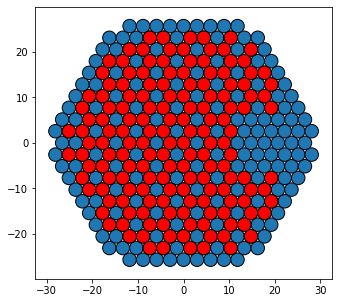

In [179]:
solidStack = StackGeometry(10, 2.958)
solidStack.build_triangular_lattice()
solidStack.trim_lattice_to_fibre()
solidStack.add_cores_from_file(core_file_path)
solidStack.show_fibre_design()

Capillary Diameter Required: 950.0
Required Fibre Diamter: 222.406015037594


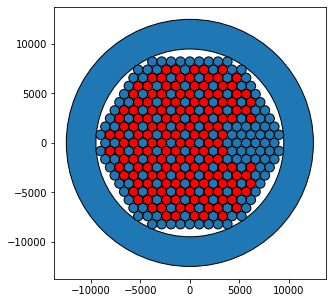

In [180]:
solidStack.choose_jacket_tube(10_000,3_500)
solidStack.choose_stack_tube(25_000, 19_000)
solidStack.scale_lattice_to_stack_size()
solidStack.show_stack_design()

In [176]:
for point in solidStack.latticePoints:
    print(point)

[-11.832      -25.61703133]
[ -8.874      -25.61703133]
[ -5.916      -25.61703133]
[ -2.958      -25.61703133]
[  0.         -25.61703133]
[  2.958      -25.61703133]
[  5.916      -25.61703133]
[  8.874      -25.61703133]
[ 11.832      -25.61703133]
[-16.269     -23.0553282]
[-13.311     -23.0553282]
[-10.353     -23.0553282]
[ -7.395     -23.0553282]
[ -4.437     -23.0553282]
[ -1.479     -23.0553282]
[  1.479     -23.0553282]
[  4.437     -23.0553282]
[  7.395     -23.0553282]
[ 10.353     -23.0553282]
[ 13.311     -23.0553282]
[ 16.269     -23.0553282]
[-17.748      -20.49362507]
[-14.79       -20.49362507]
[-11.832      -20.49362507]
[ -8.874      -20.49362507]
[ -5.916      -20.49362507]
[ -2.958      -20.49362507]
[  0.         -20.49362507]
[  2.958      -20.49362507]
[  5.916      -20.49362507]
[  8.874      -20.49362507]
[ 11.832      -20.49362507]
[ 14.79       -20.49362507]
[ 17.748      -20.49362507]
[-19.227      -17.93192193]
[-16.269      -17.93192193]
[-13.311      -1